# Topic Modelling

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from wordcloud import WordCloud, STOPWORDS


%matplotlib inline
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer

import gensim, logging, warnings
import gensim.corpora as corpora
from gensim import corpora, models
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [3]:
stop_words.extend(['look', 'smell', 'taste', 'feel', 'overall', 'rdev', 'beer', 'beers','nice','adams', 'jan', 'feb', 'mar',
                  'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'ml', 'oz', 'date',
                  'alright', 'one', 'pour', 'pours', 'gluten', 'made', 'glass', 'one', 'bit', 'maybe', 'pretty',
                  'served', 'key', 'keg', 'good', 'wonder', 'mix', 'left', 'inch', 'american', 'style', 'similar'])

In [13]:
def clean_review(review):
    """takes in a review and does the following:
    1. removes the '\xa0'
    2. removes the '\n'
    3. performs the simple preprocess from gensim"""
    review = review.replace(u'\\xa0', '')
    review = review.replace('\\n', '')
    review = gensim.utils.simple_preprocess(str(review), deacc=True)
    review = [word for word in review if word not in stop_words]
    meta_lemmed = [lemmatizer.lemmatize(word) for word in review]
#     c = " ".join(str(x) for x in meta_lemmed)
#     cleaned.append(c)
    return meta_lemmed

In [14]:
df['clean_review'] = df['review'].apply(clean_review)

In [4]:
lemmatizer = WordNetLemmatizer()

In [5]:
df = pd.read_csv("top_beers.csv", index_col=0)

In [8]:
df.shape

(41869, 19)

In [10]:
df.head()

,abv,avail,avg_score,ba_score,brewery,img,location,name,no_ratings,no_reviews,review,style,url,taste_avg,look_avg,smell_avg,feel_avg,clean_review,key_words
7,6%,Winter,3.97,88.0,Pennsylvania Brewing Company,https://cdn.beeradvocate.com/im/beers/101.jpg,Pennsylvania,St. Nikolaus Bock Bier,430,220,['3.9/5\xa0\xa0rDev -1.8%look: 4.25 | smell: 3...,German Bock,https://www.beeradvocate.com/beer/profile/125/...,3.989583,3.968750,3.687500,3.885417,"['dark', 'black', 'slight', 'tan', 'head', 'ro...",dark black slight tan head roasted barley good...
12,7%,Fall,4.01,89.0,Bierbrouwerij De Koningshoeven B.V.,https://cdn.beeradvocate.com/im/beers/101.jpg,Netherlands,La Trappe Bockbier,285,117,"[""4.15/5\xa0\xa0rDev +3.5%look: 4 | smell: 4 |...",German Bock,https://www.beeradvocate.com/beer/profile/184/...,4.080000,4.200000,4.020000,4.060000,"['deep', 'chestnut', 'ruby', 'slight', 'haze',...",deep chestnut ruby slight haze probably bottle...
17,6%,Winter,3.99,88.0,Millstream Brewing Company,https://cdn.beeradvocate.com/im/beers/101.jpg,Iowa,Schokolade Bock,180,105,['3.97/5\xa0\xa0rDev -0.5%look: 4 | smell: 3.7...,German Bock,https://www.beeradvocate.com/beer/profile/107/...,4.093750,3.916667,3.916667,4.062500,"['review', 'german', 'pilsner', 'figure', 'del...",review german pilsner figure delete erroneous ...
41,6.5%,Year-round,4.01,87.0,Aass Brewery,https://cdn.beeradvocate.com/im/beers/101.jpg,Norway,Aass Bock,65,40,['2.83/5\xa0\xa0rDev -29.4%look: 3 | smell: 3 ...,German Bock,https://www.beeradvocate.com/beer/profile/185/...,4.150000,3.960000,3.910000,3.970000,"['light', 'brown', 'pour', 'earthy', 'edge', '...",light brown pour earthy edge thin head white a...
46,6%,Rotating,3.91,86.0,Perrin Brewing Co.,https://cdn.beeradvocate.com/im/beers/101.jpg,Michigan,Poop Your Pants Chocolate Bock,52,11,['3.36/5\xa0\xa0rDev -14.1%look: 3.25 | smell:...,German Bock,https://www.beeradvocate.com/beer/profile/2995...,3.931818,3.909091,3.795455,3.863636,"['including', 'tax', 'six', 'pack', 'meijer', ...",including tax six pack meijer birch run mi und...


In [41]:
df.iloc[0]['review']

'[\'3.9/5\\xa0\\xa0rDev -1.8%look: 4.25 | smell: 3 | taste: 4.25 | feel: 3.75 | overall: 4.25Dark black beer with slight tan head, roasted barley smell, good roast taste that fades with little bitterness actually very pleasant on the palate, good light body and carbonation\\xa0180 charactersCodyBasden, May 20, 2019\', \'4.12/5\\xa0\\xa0rDev +3.8%look: 4.25 | smell: 3.5 | taste: 4.5 | feel: 3.75 | overall: 4.25Look: dark, chocolatey to deep brick read. Thin head with slight lacing.\\nSmell: hoppy and rich, like your favorite pub.\\nTaste: fresh, rich hoppy. Nice and smooth.\\nFeel: slight tang. Rich and smooth.\\nOverall: Penn brewery’s bock is quite fine. Easy to drink and very distinctive, rich flavor.\\xa0293 charactersBishopJ, Jan 12, 2019\', \'3.77/5\\xa0\\xa0rDev -5%look: 4 | smell: 3.75 | taste: 3.75 | feel: 3.75 | overall: 3.75A - Dark amber to orange brown in color with nice clarity and sticky lacing.\\n\\nS - Toasted caramel malt with some spice/cinnamon and a small hit of aci

In [16]:
id2word = corpora.Dictionary(df['clean_review'])

In [17]:
corpus = [id2word.doc2bow(text) for text in df['clean_review']]

In [21]:
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=12, random_state=42,
                                             workers=5, passes=10)

In [22]:
pprint(lda_model.print_topics())

[(0,
  '0.029*"chocolate" + 0.027*"coffee" + 0.024*"dark" + 0.017*"black" + '
  '0.015*"head" + 0.015*"stout" + 0.014*"malt" + 0.014*"roasted" + '
  '0.011*"flavor" + 0.010*"brown"'),
 (1,
  '0.018*"dark" + 0.017*"brown" + 0.016*"sweet" + 0.013*"head" + '
  '0.013*"caramel" + 0.012*"flavor" + 0.011*"malt" + 0.010*"fruit" + '
  '0.010*"cinnamon" + 0.010*"spice"'),
 (2,
  '0.021*"orange" + 0.014*"fruit" + 0.013*"head" + 0.012*"citrus" + '
  '0.012*"tropical" + 0.011*"pineapple" + 0.011*"hop" + 0.011*"mango" + '
  '0.010*"hazy" + 0.010*"flavor"'),
 (3,
  '0.036*"light" + 0.018*"head" + 0.017*"white" + 0.016*"malt" + 0.015*"hop" + '
  '0.015*"flavor" + 0.014*"aroma" + 0.014*"carbonation" + 0.012*"crisp" + '
  '0.012*"moderate"'),
 (4,
  '0.123*"raspberry" + 0.008*"head" + 0.008*"like" + 0.007*"pink" + '
  '0.007*"tart" + 0.006*"light" + 0.006*"spruce" + 0.005*"finish" + '
  '0.005*"fresh" + 0.005*"great"'),
 (5,
  '0.017*"sour" + 0.014*"tart" + 0.012*"funk" + 0.012*"like" + 0.011*"light" +

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=df['clean_review'],
                                         dictionary=id2word,
                                         coherence='c_v')
print(coherence_model_lda.get_coherence())

Maybe do the test to find best number of topics

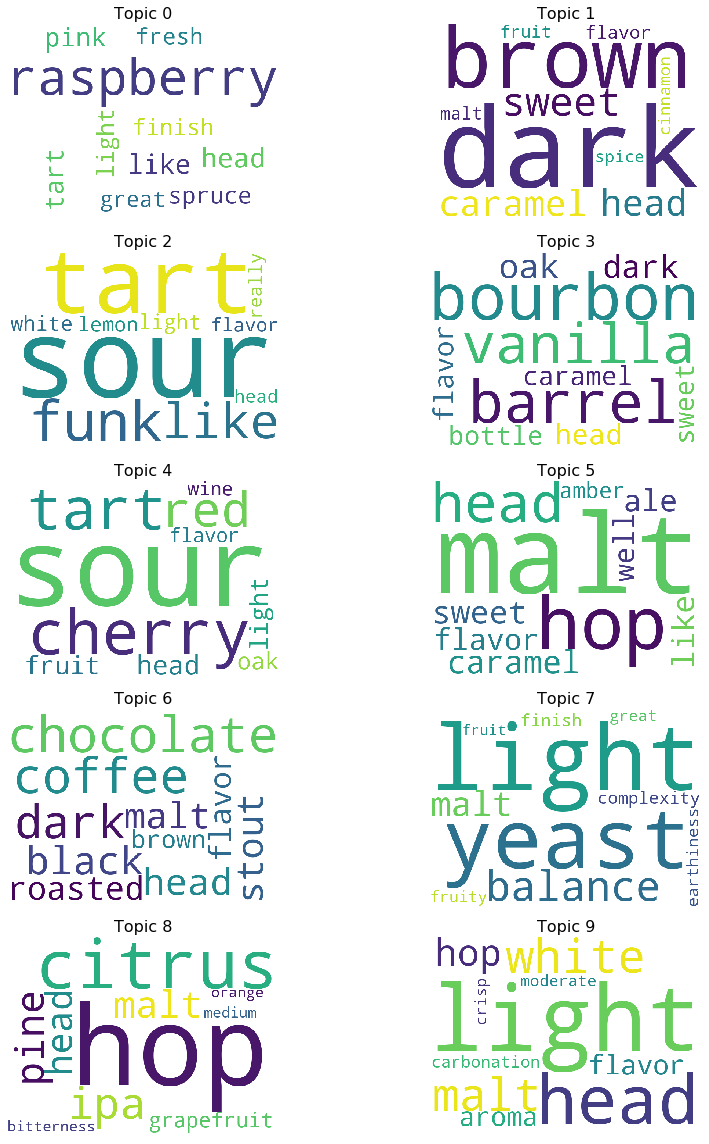

In [38]:
cloud = WordCloud(max_words= 100,
               width = 744, 
               height = 544,
               background_color ='white',
               stopwords=stop_words, 
               contour_width=3, 
               contour_color='steelblue',
               min_font_size = 10)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(14,16), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [39]:
topics

[(4,
  [('raspberry', 0.12302851),
   ('head', 0.007846165),
   ('like', 0.007612669),
   ('pink', 0.0071502896),
   ('tart', 0.0071268394),
   ('light', 0.0058516064),
   ('spruce', 0.0056587257),
   ('finish', 0.0053556934),
   ('fresh', 0.005268374),
   ('great', 0.0051367246)]),
 (1,
  [('dark', 0.01843606),
   ('brown', 0.017062347),
   ('sweet', 0.016398551),
   ('head', 0.013278934),
   ('caramel', 0.012869381),
   ('flavor', 0.011623474),
   ('malt', 0.010786349),
   ('fruit', 0.009985138),
   ('cinnamon', 0.009626598),
   ('spice', 0.009585822)]),
 (5,
  [('sour', 0.017484792),
   ('tart', 0.014173787),
   ('funk', 0.012378203),
   ('like', 0.011736799),
   ('light', 0.011028305),
   ('white', 0.01091564),
   ('lemon', 0.010705426),
   ('flavor', 0.009114683),
   ('head', 0.008668787),
   ('really', 0.00852974)]),
 (10,
  [('bourbon', 0.028893126),
   ('barrel', 0.023705266),
   ('vanilla', 0.021680865),
   ('oak', 0.014977193),
   ('dark', 0.013147385),
   ('head', 0.01000624

In [40]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

//anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.089209 -0.083358       1        1  20.781523
7      0.002146  0.032192       2        1  13.945524
2     -0.012304  0.038285       3        1  10.953330
9      0.066970  0.001010       4        1  10.492620
10     0.099233 -0.104768       5        1   8.069547
1      0.058693 -0.080862       6        1   7.949800
5     -0.009822  0.044367       7        1   6.837805
6      0.004675 -0.005023       8        1   6.136899
11    -0.021685  0.019189       9        1   6.116952
3     -0.066346  0.035863      10        1   5.707444
8     -0.261456 -0.067089      11        1   2.576760
4      0.050689  0.170194      12        1   0.431796, topic_info=      Category           Freq        Term          Total  loglift  logprob
116    Default   74901.000000      coffee   74901.000000  30.0000  30.0000
100    Default   88230.000000   chocolate   88230.000000  29.0000  29.0000
292    Default  133705.000000       light  133705.000000  28.0000  28.0000
2361   Default   30871.000000     bourbon   30871.000000  27.0000  27.0000
253    Default  128455.000000         hop  128455.000000  26.0000  26.0000
469    Default   39276.000000        sour   39276.000000  25.0000  25.0000
137    Default  112304.000000        dark  112304.000000  24.0000  24.0000
1212   Default   11356.000000   raspberry   11356.000000  23.0000  23.0000
1262   Default   33538.000000        tart   33538.000000  22.0000  22.0000
801    Default   41844.000000         ipa   41844.000000  21.0000  21.0000
2356   Default   30604.000000      barrel   30604.000000  20.0000  20.0000
547    Default   48357.000000     vanilla   48357.000000  19.0000  19.0000
573    Default   32906.000000       yeast   32906.000000  18.0000  18.0000
956    Default   43706.000000       stout   43706.000000  17.0000  17.0000
76     Default   63289.000000       brown   63289.000000  16.0000  16.0000
652    Default   67076.000000      citrus   67076.000000  15.0000  15.0000
368    Default   67491.000000      orange   67491.000000  14.0000  14.0000
562    Default   78003.000000       white   78003.000000  13.0000  13.0000
312    Default  139590.000000        malt  139590.000000  12.0000  12.0000
99     Default   24296.000000      cherry   24296.000000  11.0000  11.0000
2398   Default   31390.000000         oak   31390.000000  10.0000  10.0000
222    Default   84927.000000       fruit   84927.000000   9.0000   9.0000
55     Default   53244.000000       black   53244.000000   8.0000   8.0000
430    Default   40803.000000     roasted   40803.000000   7.0000   7.0000
40     Default   29641.000000     balance   29641.000000   6.0000   6.0000
2335   Default   32560.000000        pine   32560.000000   5.0000   5.0000
199    Default   98985.000000      finish   98985.000000   4.0000   4.0000
415    Default   23851.000000         red   23851.000000   3.0000   3.0000
8433   Default   35443.000000  grapefruit   35443.000000   2.0000   2.0000
240    Default   55644.000000       great   55644.000000   1.0000   1.0000
...        ...            ...         ...            ...      ...      ...
217    Topic12     297.234863       fresh   22010.937500   1.1402  -5.2460
2564   Topic12      77.745613         tip     782.481689   3.1359  -6.5871
4055   Topic12      96.925735       jammy    1392.523315   2.7800  -6.3666
9095   Topic12      71.273560    smoothie     664.332092   3.2127  -6.6740
7275   Topic12     103.247406     fruited    1873.948364   2.5463  -6.3034
14387  Topic12      89.217079     pinkish    1287.578125   2.7755  -6.4495
294    Topic12     429.496979        like  108418.101562  -0.0862  -4.8779
1257   Topic12     138.548874      summer    5011.598145   1.8567  -6.0093
244    Topic12     442.670532        head  171322.687500  -0.5135  -4.8477
73     Topic12     213.226868     brewery   19089.861328   0.9504  -5.5782
1215   Topic12     193.070633  refreshing   14325.3

In [42]:
f = open('topic_vis.html', 'w')
f.write(vis)
f.close()

TypeError: write() argument must be str, not PreparedData

In [49]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=df['clean_review']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
#     contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, df], axis=1)
    return(sent_topics_df)

In [48]:
df.reset_index(drop=True, inplace=True)

In [50]:
df_dominant_topic = format_topics_sentences(ldamodel=lda_model)

In [51]:
df_dominant_topic.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,abv,avail,avg_score,ba_score,brewery,img,location,...,no_reviews,review,style,url,taste_avg,look_avg,smell_avg,feel_avg,clean_review,key_words
0,1.0,0.3519,"dark, brown, sweet, head, caramel, flavor, mal...",6%,Winter,3.97,88.0,Pennsylvania Brewing Company,https://cdn.beeradvocate.com/im/beers/101.jpg,Pennsylvania,...,220,['3.9/5\xa0\xa0rDev -1.8%look: 4.25 | smell: 3...,German Bock,https://www.beeradvocate.com/beer/profile/125/...,3.989583,3.968750,3.687500,3.885417,"[dark, black, slight, tan, head, roasted, barl...",dark black slight tan head roasted barley good...
1,1.0,0.4266,"dark, brown, sweet, head, caramel, flavor, mal...",7%,Fall,4.01,89.0,Bierbrouwerij De Koningshoeven B.V.,https://cdn.beeradvocate.com/im/beers/101.jpg,Netherlands,...,117,"[""4.15/5\xa0\xa0rDev +3.5%look: 4 | smell: 4 |...",German Bock,https://www.beeradvocate.com/beer/profile/184/...,4.080000,4.200000,4.020000,4.060000,"[deep, chestnut, ruby, slight, haze, probably,...",deep chestnut ruby slight haze probably bottle...
2,0.0,0.3991,"chocolate, coffee, dark, black, head, stout, m...",6%,Winter,3.99,88.0,Millstream Brewing Company,https://cdn.beeradvocate.com/im/beers/101.jpg,Iowa,...,105,['3.97/5\xa0\xa0rDev -0.5%look: 4 | smell: 3.7...,German Bock,https://www.beeradvocate.com/beer/profile/107/...,4.093750,3.916667,3.916667,4.062500,"[review, german, pilsner, figure, delete, erro...",review german pilsner figure delete erroneous ...
3,9.0,0.7576,"malt, hop, head, caramel, sweet, like, ale, fl...",6.5%,Year-round,4.01,87.0,Aass Brewery,https://cdn.beeradvocate.com/im/beers/101.jpg,Norway,...,40,['2.83/5\xa0\xa0rDev -29.4%look: 3 | smell: 3 ...,German Bock,https://www.beeradvocate.com/beer/profile/185/...,4.150000,3.960000,3.910000,3.970000,"[light, brown, earthy, edge, thin, head, white...",light brown pour earthy edge thin head white a...
4,0.0,0.5751,"chocolate, coffee, dark, black, head, stout, m...",6%,Rotating,3.91,86.0,Perrin Brewing Co.,https://cdn.beeradvocate.com/im/beers/101.jpg,Michigan,...,11,['3.36/5\xa0\xa0rDev -14.1%look: 3.25 | smell:...,German Bock,https://www.beeradvocate.com/beer/profile/2995...,3.931818,3.909091,3.795455,3.863636,"[including, tax, six, pack, meijer, birch, run...",including tax six pack meijer birch run mi und...


In [63]:
words = []
for i in range(len(topics)):
#     words = []
    words.append(topics[i][1][1][0])
    print(words)

['brown']
['brown', 'head']
['brown', 'head', 'coffee']
['brown', 'head', 'coffee', 'head']
['brown', 'head', 'coffee', 'head', 'hop']
['brown', 'head', 'coffee', 'head', 'hop', 'citrus']
['brown', 'head', 'coffee', 'head', 'hop', 'citrus', 'head']
['brown', 'head', 'coffee', 'head', 'hop', 'citrus', 'head', 'fruit']
['brown', 'head', 'coffee', 'head', 'hop', 'citrus', 'head', 'fruit', 'cherry']
['brown', 'head', 'coffee', 'head', 'hop', 'citrus', 'head', 'fruit', 'cherry', 'tart']


In [54]:
cloud = WordCloud(max_words= 100,
               width = 744, 
               height = 544,
               background_color ='white',
               stopwords=stop_words, 
               contour_width=3, 
               contour_color='steelblue',
               min_font_size = 10)

topics = lda_model.show_topics(formatted=False)


for i in range(len(topics)):
    words = []
    words.append(topics[i][1][1][0])

cloud.generate_from_frequencies(topics, max_font_size=300)

# fig, axes = plt.subplots(5, 2, figsize=(14,16), sharex=True, sharey=True)

# for i, ax in enumerate(axes.flatten()):
#     fig.add_subplot(ax)
#     topic_words = dict(topics[i][1])
#     cloud.generate_from_frequencies(topic_words, max_font_size=300)
#     plt.gca().imshow(cloud)
#     plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
#     plt.gca().axis('off')


# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
# plt.margins(x=0, y=0)
# plt.tight_layout()
# plt.show()

plt.figure()
plt.imshow(cloud, interpolation="bilinear")
plt.axis('off')

TypeError: expected string or bytes-like object